## Small Dataset Full-Image Species Exploration 

In this notebook, we explore a small portion of Haiti Tree Project (THTP) captures labeled by Cam. These are full images and represent a small portion of the dataset (hence small). This notebook is for transfer learning using a pretrained Inception v3 classifier, same as that used by Pl@ntNet.


### Dependencies

In [1]:
import torch
import numpy as np
import pandas as pd
import os
import sklearn
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import urllib
import time
from PIL import Image

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import torchvision.models as models
from torchvision.io import read_image
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader


import requests
import json


torch.backends.cudnn.benchmark = True

### Data Retrieval
 
 
For now, download each image/label pair Cam has specified ([Github link](https://github.com/Greenstand/Tree_Species/tree/master/training)).

In [2]:
datadir = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/cam_training.psv"
baseurl = "https://treetracker-production-images.s3.eu-central-1.amazonaws.com/"
assert os.path.exists(datadir)
data = pd.read_csv(datadir, sep="|", header=None)
data.columns = ["class", "imname"]
data["url"] = baseurl + data["imname"]
data.head(5)

,class,imname,url
0,ACACAURI,2020.11.29.12.18.36_18.285143729299307_-73.564...,https://treetracker-production-images.s3.eu-ce...
1,ACACAURI,2020.11.29.12.18.59_18.285102993249893_-73.564...,https://treetracker-production-images.s3.eu-ce...
2,ACACAURI,2020.11.29.12.47.34_18.290133895352483_-73.557...,https://treetracker-production-images.s3.eu-ce...
3,ACACAURI,2020.11.29.12.50.51_18.29083981923759_-73.5582...,https://treetracker-production-images.s3.eu-ce...
4,ACACAURI,2020.11.29.13.29.55_18.29298411961645_-73.5581...,https://treetracker-production-images.s3.eu-ce...


In [3]:
savepath = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/"
for species in data["class"].unique():
    if not os.path.exists(os.path.join(savepath, species)):
        os.makedirs(os.path.join(savepath, species))
image_saver = lambda df: urllib.request.urlretrieve(df["url"], os.path.join(savepath, df["class"], df["imname"]))
data.apply(image_saver, axis=1)


0      (/home/ec2-user/SageMaker/treetracker-machine-...
1      (/home/ec2-user/SageMaker/treetracker-machine-...
2      (/home/ec2-user/SageMaker/treetracker-machine-...
3      (/home/ec2-user/SageMaker/treetracker-machine-...
4      (/home/ec2-user/SageMaker/treetracker-machine-...
                             ...                        
383    (/home/ec2-user/SageMaker/treetracker-machine-...
384    (/home/ec2-user/SageMaker/treetracker-machine-...
385    (/home/ec2-user/SageMaker/treetracker-machine-...
386    (/home/ec2-user/SageMaker/treetracker-machine-...
387    (/home/ec2-user/SageMaker/treetracker-machine-...
Length: 388, dtype: object

388  total samples
Class breakdown
{'ACACAURI': 111, 'ANACOCCI': 53, 'CATALONG': 75, 'MANGINDI': 149}
4  classes found


Text(0.5, 1.0, 'Count per class')

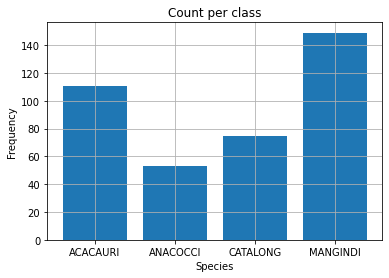

In [4]:
print (data.shape[0], " total samples")
print ("Class breakdown")
count_by_class = data.groupby("class").aggregate("count")
baseline_acc = np.max
print (dict(zip(count_by_class.index, count_by_class.values[:, 0])))
num_classes = data["class"].unique().shape[0]
print (num_classes, " classes found")
plt.bar(count_by_class.index, count_by_class["imname"])
plt.grid()
plt.xlabel("Species")
plt.ylabel("Frequency")
plt.title("Count per class")

In [5]:
arrs = []
labels = []
for species in data["class"].unique():
    for img in os.listdir(os.path.join(savepath, species)):
        if os.path.splitext(os.path.join(savepath, species, img))[1].lower() in [".jpg", ".png"]:
            arrs.append(Image.open(os.path.join(savepath, species, img)).resize((224, 224)))
            labels.append(species)
            


In [6]:
X = np.vstack([np.array(img.resize((28, 28))).flatten() for img in arrs])
pca = PCA(n_components=50)
X_red = pca.fit_transform(X)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_ * 100))
print (np.sum(pca.explained_variance_ratio_) * 100 , "% variance explained total")

Explained variation per principal component: [15.39053031  7.30257177  5.59287422  3.53779183  2.75368991  2.58201922
  1.93805459  1.88549047  1.65496859  1.42914788  1.33058396  1.23747025
  1.17390167  1.07488067  1.00165761  0.98831081  0.93794412  0.88085138
  0.8416408   0.80209349  0.74512242  0.72747393  0.71024784  0.67200528
  0.64602617  0.62597874  0.60923845  0.58232751  0.57005082  0.54664809
  0.53427954  0.5311068   0.51982752  0.4980975   0.49377969  0.4835947
  0.46861379  0.44856112  0.43614431  0.4294526   0.42169868  0.4045496
  0.39535723  0.38852312  0.38203735  0.37578392  0.36759989  0.35758384
  0.35426217  0.3434504 ]
69.40589657116428 % variance explained total


In [7]:
X_embedded = TSNE(n_components=2, perplexity=80.0, learning_rate=24.0, n_iter=10000).fit_transform(X_red)
tsne_result = pd.DataFrame(X_embedded)
tsne_result["class"] = labels
tsne_result.columns = ["x0", "x1", "class"]
colors = np.linspace(0, 1, len(data["class"].unique()))
colordict = dict(zip(data["class"].unique(), colors))  
tsne_result["Color"] = tsne_result["class"].apply(lambda x: colordict[x])

In [8]:
print (tsne_result.head(5))

         x0        x1     class  Color
0 -1.383637  0.251317  ACACAURI    0.0
1  1.719277  3.239909  ACACAURI    0.0
2 -0.087211 -0.502661  ACACAURI    0.0
3  1.443821 -0.763492  ACACAURI    0.0
4 -0.031881  0.847658  ACACAURI    0.0


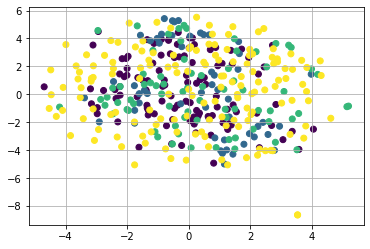

In [9]:
plt.grid()
plt.scatter(tsne_result["x0"], tsne_result["x1"], c=tsne_result["Color"], label=tsne_result["class"])


In [37]:
class HaitiDataset(torch.utils.data.Dataset):
    def __init__(self, df, loadpath, transform, encoding):
        '''
        A dataset with image names, classes, and a provided loading path to load images from
        '''
        self.loadpath = loadpath
        self.data = df
        self.n_classes = self.data["class"].unique().shape[0]
        self.transform = transform
        self.numerical_encoding = dict(zip(sorted(list(self.data["class"].unique())), list(range(self.n_classes))))
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.loadpath, self.data.iloc[idx, :]["class"], self.data.iloc[idx, :]["imname"])
        label = self.data.iloc[idx, :]["class"]
        img = self.transform(Image.open(img_path))
        label = self.numerical_encoding[label]
        return img, label
        
    def make_class_weighting(self):
        count_by_class = data.groupby("class").aggregate("count") 
        count_by_class = count_by_class / count_by_class.sum()
        count_by_class.index = count_by_class.index.map(self.numerical_encoding)
        return count_by_class.values[:, 0]


In [45]:
val_split = 0.3
num_epochs = 200

idxs = np.arange(data.shape[0])
np.random.shuffle(idxs)

tr_idxs = idxs[:int (val_split * data.shape[0]), ...]
val_idxs = idxs[int (val_split * data.shape[0]):, ...]

tr_dataset = HaitiDataset(data.iloc[tr_idxs, :], savepath, transform, None)
val_dataset = HaitiDataset(data.iloc[val_idxs, :], savepath, transform, None)

tr_dataloader = DataLoader(tr_dataset, batch_size=4, shuffle=True, num_workers=1, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_idxs.shape[0], shuffle=True, num_workers=1, pin_memory=True)



In [46]:

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            

transform = T.Compose([T.Resize(512), 
                       T.CenterCrop(299), 
                       T.RandomRotation(degrees=(0, 20)),
                       T.RandomHorizontalFlip(p=0.5), 
                       T.ColorJitter(), 
                       T.ToTensor()])

inception = models.inception_v3(pretrained=True)
set_parameter_requires_grad(inception, feature_extracting=True)
num_ftrs = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = torch.nn.Linear(num_ftrs, num_classes)
# Handle the primary net
num_ftrs = inception.fc.in_features
inception.fc = torch.nn.Linear(num_ftrs,num_classes)

params_to_update = []
for name, param in inception.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("Device: ", device)

class_weights = tr_dataset.make_class_weighting()
criterion = torch.nn.CrossEntropyLoss(reduction="mean", weight=torch.Tensor(class_weights)).cuda()
inception = inception.to(device)
optimizer = torch.optim.Adam(params_to_update, lr=0.005)

Device:  cuda:0


In [47]:
print (data.head(5))

      class                                             imname  \
0  ACACAURI  2020.11.29.12.18.36_18.285143729299307_-73.564...   
1  ACACAURI  2020.11.29.12.18.59_18.285102993249893_-73.564...   
2  ACACAURI  2020.11.29.12.47.34_18.290133895352483_-73.557...   
3  ACACAURI  2020.11.29.12.50.51_18.29083981923759_-73.5582...   
4  ACACAURI  2020.11.29.13.29.55_18.29298411961645_-73.5581...   

                                                 url  
0  https://treetracker-production-images.s3.eu-ce...  
1  https://treetracker-production-images.s3.eu-ce...  
2  https://treetracker-production-images.s3.eu-ce...  
3  https://treetracker-production-images.s3.eu-ce...  
4  https://treetracker-production-images.s3.eu-ce...  


In [48]:
for epoch in range(num_epochs):
    running_loss = 0
    start = time.time()
    tr_acc_sum = 0
    tr_samples = 0
    n_tr_batches = 0
    for batch_x, batch_y in tr_dataloader:
        n_tr_batches += 1
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = inception.forward(batch_x)
        loss = criterion(output.logits, batch_y)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        tr_acc_sum += torch.sum(torch.argmax(output.logits, dim=1) == batch_y)
        tr_samples += batch_y.size()[0]
    with torch.no_grad():
        n_val_batches = 0
        val_samples = 0
        running_val_loss = 0
        val_acc_sum = 0
        for val_x, val_y in val_dataloader:
            n_val_batches += 1
            val_x = val_x.to(device)
            val_y = val_y.to(device)
            val_output = inception.forward(val_x)
            val_loss = criterion(val_output.logits, val_y)
            running_val_loss += val_loss.item()
            val_acc_sum += torch.sum(torch.argmax(val_output.logits, dim=1) == val_y) # wrote this way just in case there's batched validation
            val_samples += val_y.size()[0]
    print ("Epoch %d finished in %f seconds"%(epoch + 1, time.time() - start))
    print ("Training/Validation Loss per Batch: %f/ %f"%(running_loss / n_tr_batches, running_val_loss / n_val_batches))
    print ("Training/Validation Accuracy (percent): %f /%f"%(100 * tr_acc_sum / tr_samples, 100 * val_acc_sum / val_samples))
    print ("=" * 40)
print ("Finished training")

Epoch 1 finished in 16.082183 seconds
Training/Validation Loss per Batch: 2.180291/ 1.508424
Training/Validation Accuracy (percent): 37.068966 /54.779411
Epoch 2 finished in 16.055562 seconds
Training/Validation Loss per Batch: 1.119268/ 1.558210
Training/Validation Accuracy (percent): 52.586208 /44.852940
Epoch 3 finished in 16.048801 seconds
Training/Validation Loss per Batch: 1.179136/ 1.458229
Training/Validation Accuracy (percent): 57.758621 /40.808823
Epoch 4 finished in 15.999604 seconds
Training/Validation Loss per Batch: 1.121688/ 0.855882
Training/Validation Accuracy (percent): 53.448277 /62.867649
Epoch 5 finished in 16.092896 seconds
Training/Validation Loss per Batch: 0.851655/ 1.232967
Training/Validation Accuracy (percent): 69.827583 /59.558823
Epoch 6 finished in 16.278125 seconds
Training/Validation Loss per Batch: 0.741221/ 0.638234
Training/Validation Accuracy (percent): 64.655174 /68.750000
Epoch 7 finished in 16.240560 seconds
Training/Validation Loss per Batch: 0.

In [68]:
# Pl@ntNet comparison

username = "shubhomb"
API_KEY = "2b10apPYIJgFw5XTChueBLJXfe"

from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

api_endpoint = "https://my-api.plantnet.org/v2/identify/all?api-key=%s"%API_KEY
# path = os.path.join(savepath, tr_dataset.data.iloc[0]["class"], tr_dataset.data.imname[0])

session = requests.Session()
retry = Retry(connect=1, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

def get_plantnet_result(df):
    df = df.T
    path = os.path.join(savepath, df["class"], df["imname"])
    try:
        files = [
        ('images', (path, open(path, "rb"))),
        ]
    except:
        return None
    reqdata={'organs':['flowers','leaf']}

    json_result = None
    print ("Found image, continuing to HTTP stuff")
    req = requests.Request('POST', url=api_endpoint, files=files, data=reqdata)
    prepared = req.prepare()
    print (req)
    response = s.send(prepared)
    print (response)
    json_result = json.loads(response.text)
    time.sleep(5.0)
    return json_result

species_output = data.apply(get_plantnet_result, axis=1)
print (species_output)

Found image, continuing to HTTP stuff
<Request [POST]>


ConnectionError: HTTPSConnectionPool(host='my-api.plantnet.org', port=443): Max retries exceeded with url: /v2/identify/all?api-key=2b10apPYIJgFw5XTChueBLJXfe (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f9d90360860>: Failed to establish a new connection: [Errno 110] Connection timed out',))